# Modeling
In this notebook, I will load the cleaned, pre-processed data, perform additional data preparations for modeling, and try out a few models to predict negative reviews.

## Setup
### Install TensorFlow 2.0
I chose to use TensorFlow 2.0 to model the dataset. Google Colab does not currently support TensorFlow 2.0. I can work around this by uninstalling TensorFlow and installing TensorFlow 2.0

In [1]:
!pip uninstall --yes tensorflow
!pip install tensorflow==2.0.0

Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 86.3MB 73kB/s 
     |████████████████████████████████| 3.8MB 41.4MB/s 
     |████████████████████████████████| 450kB 34.3MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


Import Python libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import sys
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.backend import clear_session
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from google.colab import drive
from importlib.machinery import SourceFileLoader

%matplotlib inline

print(f'TensorFlow Version {tf.__version__}')

TensorFlow Version 2.0.0


Mount Google Drive

In [0]:
ROOT = '/content/drive'
PROJECT = 'My Drive/Thinkful/Final_Capstone_Project/'
PROJECT_PATH = os.path.join(ROOT, PROJECT)

In [3]:
drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Load custom constants and methods.

In [0]:
con = SourceFileLoader('constants', os.path.join(PROJECT_PATH, 'utilities/constants.py')).load_module()
met = SourceFileLoader('methods', os.path.join(PROJECT_PATH, 'utilities/methods.py')).load_module()

## Load Data
Read in the cleaned dataset.

In [0]:
# df_clean = pd.read_csv(os.path.join(PROJECT_PATH, 'data/cleaned_full.csv'))
df_clean = pd.read_csv(os.path.join(PROJECT_PATH, 'data/cleaned_extremes.csv'))

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4608 entries, 0 to 4607
Data columns (total 3 columns):
clean_text    4608 non-null object
text_seq      4608 non-null object
labels        4608 non-null int64
dtypes: int64(1), object(2)
memory usage: 108.1+ KB


## Data Preparation
Gather features and labels.

In [0]:
X = df_clean['text_seq'].values
y = df_clean['labels'].values

Split dataset into train and test sets.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
print(f'The fraction of negative reviews in the training set is {np.sum(y_train) / len(y_train):0.3f}.')
print(f'The fraction of negative reviews in the test set is {np.sum(y_test) / len(y_test):0.3f}.')

The fraction of negative reviews in the training set is 0.116.
The fraction of negative reviews in the test set is 0.116.


In [10]:
print(f'Train count: [{len(y_train) - np.sum(y_train)}, {np.sum(y_train)}] ([positive, negative])')

Train count: [3260, 426] ([positive, negative])


In [11]:
print(f'Test count: [{len(y_test) - np.sum(y_test)}, {np.sum(y_test)}] ([positive, negative])')

Test count: [815, 107] ([positive, negative])


In [0]:
y_train_one_hot = y_train.reshape((len(y_train), 1))
y_test_one_hot = y_test.reshape((len(y_test), 1))

### Text Encoding
When modeling this dataset, the words need to be encoded as numbers, since a computer only understands numbers and not strings. I will consider two encoding approaches:

* TF-IDF
* Word Embeddings

#### TF-IDF and Vectorization
For this step, I will use Scikit-Learn's **`TfidfVectorizer()`** to convert the text corpus into feature vectors. This algorithm will first create a vocabulary by finding all of the unique words in the corpus. Each word in each document in the corpus will be assigned a floating point number. This number is comprised of a count of how many times that word is used in the document, weighted by the inverse frequency of that word in the full corpus. Thus, words that are used frequently will be given less weight, while words that are not common will get more weight. This makes sense since words that are used a lot provide little information as related to the outcome variable. For example, if the word _the_ appears in all of the documents, the neural network will have a hard time differntiating between positive and negative reviews.

The **`TfidfVectorizer()`** can be further customized to restrict the vocabulary to a smaller size, such as only including the _n_ most frequent words.

In [13]:
print(f'The vocabulary size is {con.VOCAB_SIZE}.')

The vocabulary size is 9566.


In [0]:
vectorizer = TfidfVectorizer(max_features=2500)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Modeling
First, try a very simple Multi-Layer Perceptron model.

In [0]:
met.set_params(con.PARAMS, 'input_shape', X_test_vectorized.shape[1])
met.set_params(con.PARAMS, 'epochs', 10)
met.set_params(con.PARAMS, 'batch_size', 256)

In [0]:
clear_session()
model = met.build_mlp_model(metrics=con.METRICS, params=con.PARAMS)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1280512   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 1,543,681
Trainable params: 1,543,681
Non-trainable params: 0
_________________________________________________________________


In [18]:
train_history = model.fit(X_train_vectorized,
                        y_train,
                        batch_size=con.PARAMS['batch_size'],
                        epochs=con.PARAMS['epochs'],
                        verbose=0,
                        validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(train_history.history, index=train_history.epoch)

In [20]:
df_train_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 18 columns):
loss             10 non-null float64
tp               10 non-null float64
fp               10 non-null float64
tn               10 non-null float64
fn               10 non-null float64
accuracy         10 non-null float64
precision        10 non-null float64
recall           10 non-null float64
auc              10 non-null float64
val_loss         10 non-null float64
val_tp           10 non-null float64
val_fp           10 non-null float64
val_tn           10 non-null float64
val_fn           10 non-null float64
val_accuracy     10 non-null float64
val_precision    10 non-null float64
val_recall       10 non-null float64
val_auc          10 non-null float64
dtypes: float64(18)
memory usage: 1.5 KB


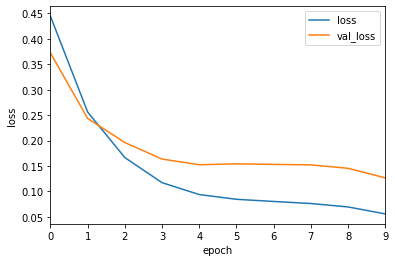

In [21]:
df_train_history.loc[:, ['loss', 'val_loss']].plot()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


In [22]:
mlp_test_history = model.evaluate(X_test_vectorized, y_test, batch_size=con.PARAMS['batch_size'], verbose=0)

In [23]:
met.print_test_results(model, mlp_test_history)

loss: 0.06890895395436669
tp: 98.0
fp: 0.0
tn: 815.0
fn: 9.0
accuracy: 0.990238606929779
precision: 1.0
recall: 0.9158878326416016
auc: 0.9950346946716309


## Word Embeddings
Preparing data for word embeddings.
1. Split sequences in X_train and X_test. 
2. Find largest review length from split sequences.
3. Encode X_train and X_test into one hot vectors.
4. Pad each encoded feature using max review length.
5. Define vocabulary size.
6. Build out model.

In [24]:
max_review_length = np.max([len(x.split()) for x in X_train] + [len(x.split()) for x in X_test])
print(f'The longest cleaned review has {max_review_length} words.')

The longest cleaned review has 422 words.


In [25]:
print(f'The voculary size is {con.VOCAB_SIZE}.')

The voculary size is 9566.


In [0]:
X_train_encoded = [one_hot(x, con.VOCAB_SIZE*1.3) for x in X_train]
X_test_encoded = [one_hot(x, con.VOCAB_SIZE*1.3) for x in X_test]

In [0]:
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_review_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_review_length, padding='post')

In [0]:
y_train_one_hot = y_train.reshape((len(y_train), 1))
y_test_one_hot = y_test.reshape((len(y_test), 1))

In [0]:
met.set_params(con.PARAMS, 'epochs', 3)
met.set_params(con.PARAMS, 'batch_size', 32)
met.set_params(con.PARAMS, 'vocab_size', int(con.VOCAB_SIZE*1.3))
met.set_params(con.PARAMS, 'embedding_size', 128)
met.set_params(con.PARAMS, 'input_length', max_review_length)
met.set_params(con.PARAMS, 'lstm_units', 200)
met.set_params(con.PARAMS, 'drop_out_prob', 0.2)

In [0]:
clear_session()
model = met.build_lstm_model(metrics=con.METRICS, params=con.PARAMS)

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 422, 128)          1591680   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               263200    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 1,855,081
Trainable params: 1,855,081
Non-trainable params: 0
_________________________________________________________________


In [0]:
# lstm_history = model.fit(X_train_padded, 
#                          y_train_one_hot, 
#                          batch_size=con.PARAMS['batch_size'], 
#                          epochs=con.PARAMS['epochs'], 
#                          verbose=0, 
#                          validation_split=0.1)

In [0]:
# df_train_history = pd.DataFrame(lstm_history.history, index=lstm_history.epoch)

In [0]:
# df_train_history.loc[:, ['loss', 'val_loss']].plot()
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

In [0]:
# df_train_history.loc[:, ['val_accuracy', 'accuracy']].plot()
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.show()

In [0]:
# lstm_test_history = model.evaluate(X_test_padded, y_test_one_hot, batch_size=con.PARAMS['batch_size'], verbose=0)
# lstm_test_history = model.evaluate(X_test_padded, y_test_one_hot, batch_size=len(y_test_one_hot), verbose=0)
# lstm_test_history = model.evaluate(X_test_padded, y_test_one_hot, batch_size=64, verbose=0)

In [0]:
# met.print_test_results(model, lstm_test_history)

### Embedding only
Trying a plain embedding, feed-forward model.

In [0]:
met.set_params(con.PARAMS, 'vocab_size', int(con.VOCAB_SIZE*1.5))
met.set_params(con.PARAMS, 'embedding_size', 128)
met.set_params(con.PARAMS, 'input_length', max_review_length)
met.set_params(con.PARAMS, 'epochs', 5)
met.set_params(con.PARAMS, 'batch_size', 128)

In [56]:
int(con.VOCAB_SIZE*1.5)

14349

In [0]:
clear_session()
model = met.build_embedding_model(metrics=con.METRICS, params=con.PARAMS)

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 422, 128)          1836672   
_________________________________________________________________
flatten (Flatten)            (None, 54016)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               13504250  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 15,341,173
Trainable params: 15,341,173
Non-trainable params: 0
_________________________________________________________________


In [0]:
embedding_history = model.fit(X_train_padded,
                              y_train_one_hot, 
                              batch_size=con.PARAMS['batch_size'],
                              epochs=con.PARAMS['epochs'], 
                              verbose=0,
                              validation_split=0.1)

In [0]:
df_train_history = pd.DataFrame(embedding_history.history, index=embedding_history.epoch)

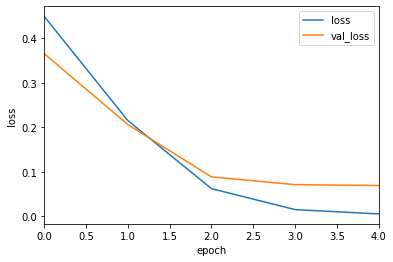

In [61]:
df_train_history.loc[:, ['loss', 'val_loss']].plot()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

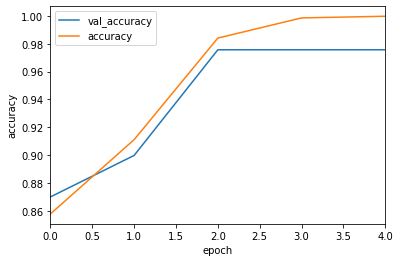

In [62]:
df_train_history.loc[:, ['val_accuracy', 'accuracy']].plot()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [0]:
embed_test_history = model.evaluate(X_test_padded, 
                                    y_test_one_hot, 
                                    batch_size=con.PARAMS['batch_size'], 
                                    verbose=0)

In [64]:
met.print_test_results(model, embed_test_history)

loss: 0.05482434210874577
tp: 97.0
fp: 4.0
tn: 811.0
fn: 10.0
accuracy: 0.9848155975341797
precision: 0.9603960514068604
recall: 0.9065420627593994
auc: 0.9949314594268799


In [0]:
y_pred = model.predict_classes(X_test_padded)

In [66]:
y_pred.flatten().shape

(922,)

In [67]:
np.unique(y_pred)

array([0, 1], dtype=int32)

In [0]:
dict_predict = {
    'text': X_test,
    'labels': y_pred.flatten()
}

In [0]:
df_prediction = pd.DataFrame(dict_predict)

In [70]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 2 columns):
text      922 non-null object
labels    922 non-null int32
dtypes: int32(1), object(1)
memory usage: 10.9+ KB


In [71]:
df_prediction.head()

,text,labels
0,time gf little brother want celebrate birthday...,0
1,come Aunties Bday greet sit right away let tel...,0
2,come Sunday crowd choose seat indoor love wood...,0
3,pho place special pho able finish bowl filling...,0
4,Rey hungry night decide place good food good p...,0


In [0]:
df_negative_reviews = df_prediction[df_prediction['labels'] == 1].copy()

In [73]:
df_negative_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 11 to 909
Data columns (total 2 columns):
text      101 non-null object
labels    101 non-null int32
dtypes: int32(1), object(1)
memory usage: 2.0+ KB


In [74]:
df_negative_reviews.head()

,text,labels
11,food okay bit underwhelming honest service big...,1
13,colleague reservation end treat delicious port...,1
17,take husband celebrate birthday adult kid come...,1
26,come happy hour Friday order food come right A...,1
27,colleague reservation end treat delicious port...,1


In [0]:
df_negative_reviews.to_csv(os.path.join(PROJECT_PATH, 'data/negative_review_predictions-extremes.csv'), index=False)

### XGBoost

In [0]:
x_class = XGBClassifier()
x_class.fit(X_train_vectorized, y_train)
y_pred = x_class.predict(X_test_vectorized)

In [77]:
confusion_matrix(y_test, y_pred)

array([[815,   0],
       [ 52,  55]])

Try XGBoost with five-fold cross validation.

In [0]:
x_class = XGBClassifier()
x_class.fit(X_train_vectorized, y_train)
score = cross_validate(x_class, X_train_vectorized, y_train, cv=5)
y_pred = x_class.predict(X_test_vectorized)

In [79]:
print(np.mean(score['test_score']), np.std(score['test_score']))

0.9441149757494861 0.008836524532438418


In [80]:
confusion_matrix(y_test, y_pred)

array([[815,   0],
       [ 52,  55]])